# Punzi and Signal Purity Scans

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import pandas as pd
from joblib import load
plt.style.use([hep.style.ROOT, hep.style.firamath])

In [2]:
version = '9.0.5'
train = pd.read_csv(f'../data_files/{version}/train.csv', index_col=[0])
X_train = train.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_train = train.category

val = pd.read_csv(f'../data_files/{version}/val.csv', index_col=[0])
X_val = val.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_val = val.category

test = pd.read_csv(f'../data_files/{version}/test.csv', index_col=[0])
X_test = test.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_test = test.category

## Load Models

In [4]:
nn = tf.keras.models.load_model(f'../neural_network/models/v{version}')
old_nn = tf.keras.models.load_model(f'../neural_network/models/v{version}')
knn = load(f'../classification_methods/models/KNN_{version}_tune.joblib')
rfc = load(f'../classification_methods/models/RFC_{version}_tune.joblib')
dtc = load(f'../classification_methods/models/DTC_{version}_tune.joblib')

models = {'NN': nn, 'KNN': knn, 'RFC': rfc, 'DTC': dtc, 'OLDNN': old_nn}

2022-03-25 14:24:59.898732: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-25 14:24:59.904572: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Signal Purity

In [5]:
def get_purity(labels, predictions, p):
    # Of everything I selected how much was correctly ID'd as signal?
    # purity = no. of events selected as signal && signal / no. of events selected
    purities = []
    for j in p:
        classes = np.where(predictions.flatten() > j, 1, 0).flatten()
        purity = np.count_nonzero(np.logical_and(classes, labels))/np.count_nonzero(classes)
        purities.append(purity)
    return np.array(purities)

## Punzi Figure-of-Merit

In [21]:
def cubic(x, p3, p2, p1, p0):
    return p3*x**3 + p2*x**2 + p1*x + p0

In [46]:
def get_punzi(labels, predictions, masses, p, a=5, sregion=[5200, 5800], bins=60):
    from scipy.integrate import quad
    from scipy.optimize import curve_fit
    punzis = []
    for j in p:
        classes = np.where(predictions > j, 1, 0).flatten()
        bg_masses = np.array([m for i, m in enumerate(masses) if (classes[i] == 1) and (labels[i] == 0)])
        # What are the masses of all the events which we said were signal but actually background (got through)
        #sig_masses = np.array([m for i, m in enumerate(masses) if (classes[i]==1) and (labels[i]==1)])
        # What are the masses of all the events which we said were signal and were signal (estimate total amount of signal)
        h, bs = np.histogram(bg_masses-5500, bins=bins)
        # shift the cut_masses by 5.5 GeV for fitting reasons
        
        # Refit the residual background
        bin_centres = np.array([np.mean(bs[i:i+2]) for i in range(len(bs)-1)])
        data = np.array([bin_centres, h.flatten(), np.sqrt(h.flatten())]).T
        data = data[data[:,1] != 0]
        # Remove the bins with no data present
        
        #efficiency = np.count_nonzero(np.logical_and(classes, labels))/np.count_nonzero(labels)
        # The number of signal events correctly identified divied by the number of signal events 
        #popt = curve_fit(quadratic, [np.mean(bins[i:i+2]) for i in range(len(bins)-1)], h, [2.44251065e-01], np.sqrt(h))[0]
        #nbg = quad(quadratic, sregion[0], sregion[1], args=(popt[0]))[0]
        #punzi = efficiency/(a/2 + np.sqrt(nbg))
        #punzis.append(punzi)
    return data

In [66]:
b = get_punzi(y_test.to_numpy(), nn.predict(X_test).flatten(), test['Lb_M'], [0.5], bins=40)

In [57]:
def wrapped_cubic(x, N):
    return N*cubic(x, 9.254546221042552e-08, -1.954917162621531e-05, -0.20807214015665842, 208.8967046045883)

In [67]:
from scipy.optimize import curve_fit

popt, pcov = curve_fit(wrapped_cubic, b[:,0], b[:,1], [0.05], b[:,2])

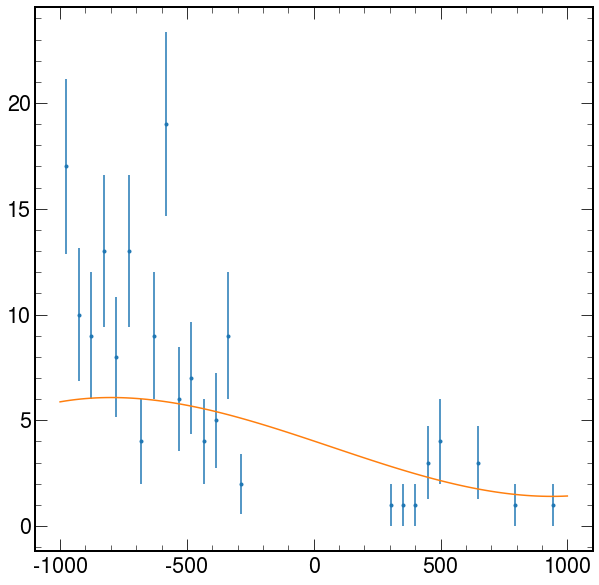

In [68]:
x = np.linspace(-1000, 1000, 100)

plt.errorbar(b[:,0], b[:,1], yerr=b[:,2], fmt='.')
plt.plot(x, wrapped_cubic(x, *popt))

## Testing Models

In [18]:
test_range = np.linspace(0.1, 0.9, 150)

/cvmfs/lhcbdev.cern.ch/conda/envs/default/2021-09-07_04-06/linux-64/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/cvmfs/lhcbdev.cern.ch/conda/envs/default/2021-09-07_04-06/linux-64/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


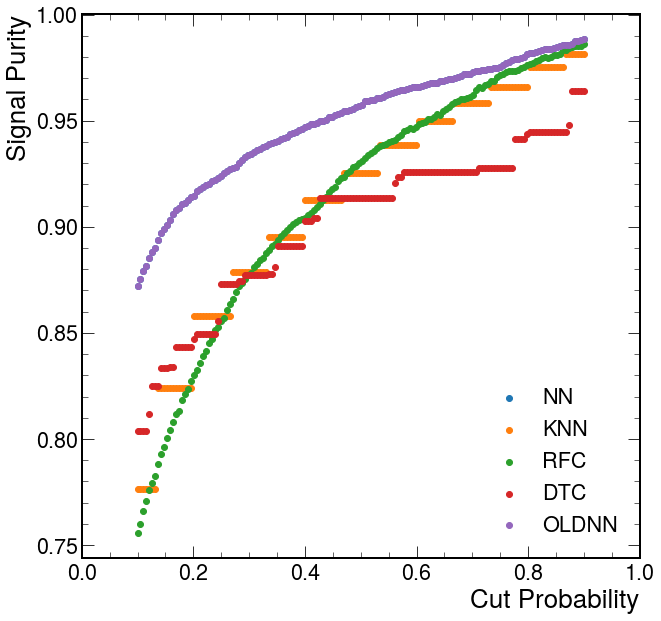

In [20]:
purities = []
for model_name, model in models.items():
    try:
        pred = model.predict_proba(X_test)[:,1].flatten()
    except:
        pred = model.predict(X_test).flatten()
    purities.append(get_purity(y_test.to_numpy(), pred, test_range))

fig, ax = plt.subplots(1, 1)
i = 0
for model_name, model in models.items():
    ax.scatter(test_range, purities[i], label=model_name)
    i += 1
ax.set_xlim(0, 1)
plt.xlabel('Cut Probability')
plt.ylabel('Signal Purity')
plt.legend()
plt.savefig('../images/ModelEval/SignalPurity_AllModels.png', dpi=800)
plt.show()